# IHLT Lab 5: Lexical Semantics

**Authors:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu)), Carlos Jiménez ([carlos.humberto.jimenez](mailto:carlos.humberto.jimenez@estudiantat.upc.edu))*

### 2024-10-17

**Instructions:**

- Given the following (lemma, category) pairs:

`(’the’,’DT’), (’man’,’NN’), (’swim’,’VB’), (’with’, ’PR’), (’a’, ’DT’),
(’girl’,’NN’), (’and’, ’CC’), (’a’, ’DT’), (’boy’, ’NN’), (’whilst’, ’PR’),
(’the’, ’DT’), (’woman’, ’NN’), (’walk’, ’VB’)`

- For each pair, when possible, print their most frequent WordNet synset

- For each pair of words, when possible, print their corresponding least common subsumer (LCS) and their similarity value, using the following functions:

    - Path Similarity

    - Peacock-Chodorow Similarity

    - Wu-Palmer Similarity

    - Lin Similarity

Normalize similarity values when necessary. What similarity seems better?

## Notes

- we should normalize the lch_similarity (not all trees have the same depth)
- most frequent ~= most likely
- lemmas have an attribute 'count'
- given synsets we can get lemmas and counts
- we should established rules/criteria to identify which similarity is 'best'
- not all the words have an entry in wordnet, in that case computing the similarity is not possible
  - we should compute our own sorting method by lemmas count


## Setup

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import sentiwordnet as swn
import math
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('sentiwordnet')
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

## helper methods

In [3]:
def get_max_depth(pos: str):
    return max(synset.max_depth() for synset in wn.all_synsets(pos))


def normalized_lch_similarity(synset1, synset2, pos: str):
    lch_sim = wn.lch_similarity(synset1, synset2)
    return 1 / (1 + math.exp((get_max_depth(pos) - lch_sim) / get_max_depth(pos)))  # Sigmoid function


## WordNet Similarities

## SentiWordnet 

In [4]:
# getting the wordnet synset
synset = wn.synset('good.a.1')
# getting the sentiwordnet synset
sentiSynset = swn.senti_synset(synset.name())

sentiSynset.pos_score(), sentiSynset.neg_score(), sentiSynset.obj_score()

(0.75, 0.0, 0.25)

In [5]:
words = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

In [6]:
synset_pos_converter = {
    'NN': 'n',
    'VB': 'v',
}

In [7]:
def get_most_frequent_synset(word, pos):
    max_count = 0
    most_frequent_synset = None 

    for synset in wn.synsets(word, pos):
        for lemma in synset.lemmas():
            if lemma.name() == word and lemma.count() > max_count:
                max_count = lemma.count()
                most_frequent_synset = synset.name()
                    
    return most_frequent_synset

In [8]:

words_df = pd.DataFrame(words,columns=['word', 'pos'])
words_df['synset_pos'] = words_df['pos'].apply(lambda pos: synset_pos_converter[pos] if pos in synset_pos_converter else None)
words_df.sort_values(by='synset_pos', inplace=True)
words_df.reset_index(drop=True, inplace=True)

print(f"Null values:\n{words_df.isnull().sum()}")
words_df.dropna(inplace=True)
print(f"Null values:\n{words_df.isnull().sum()}")

words_df['synset_accessor'] = words_df.apply(lambda row: get_most_frequent_synset(row['word'], row['synset_pos']), axis=1)
words_df


Null values:
word          0
pos           0
synset_pos    7
dtype: int64
Null values:
word          0
pos           0
synset_pos    0
dtype: int64


,word,pos,synset_pos,synset_accessor
0,man,NN,n,man.n.01
1,girl,NN,n,girl.n.01
2,boy,NN,n,male_child.n.01
3,woman,NN,n,woman.n.01
4,swim,VB,v,swim.v.01
5,walk,VB,v,walk.v.01


In [9]:
def get_similarity_matrix(words_df: pd.DataFrame, similarity_fn: callable) -> pd.DataFrame:
    similarity_matrix = pd.DataFrame(columns=words_df['word'], index=words_df['word'])
    for _, (word1, _, _, word1_synset_accessor) in words_df.iterrows():
        word1_synset = wn.synset(word1_synset_accessor)
        for _, (word2, _, _, word2_synset_accessor) in words_df.iterrows():
            word2_synset = wn.synset(word2_synset_accessor)
            similarity_matrix.loc[word1, word2] = similarity_fn(word1_synset, word2_synset)
    return similarity_matrix

## Path similarities

In [10]:
verb_words = words_df[words_df['synset_pos'] == 'v']['word'].tolist()
noun_words = words_df[words_df['synset_pos'] == 'n']['word'].tolist()

In [11]:
# path_similarities = get_similarity_matrix(words_df, wn.path_similarity)
path_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
path_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], wn.path_similarity)
path_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], wn.path_similarity)
path_similarities = path_similarities.astype(float).fillna(0)
path_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.250000,0.333333,0.333333,0.000000,0.000000
girl,0.250000,1.000000,0.166667,0.500000,0.000000,0.000000
boy,0.333333,0.166667,1.000000,0.200000,0.000000,0.000000
woman,0.333333,0.500000,0.200000,1.000000,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333
walk,0.000000,0.000000,0.000000,0.000000,0.333333,1.000000


## lch similarities

In [12]:
lch_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
lch_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], partial(normalized_lch_similarity, pos='v'))
lch_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], partial(normalized_lch_similarity, pos='n'))
lch_similarities = lch_similarities.astype(float).fillna(0)

lch_similarities

word,man,girl,boy,woman,swim,walk
man,0.308200,0.292865,0.296010,0.296010,0.000000,0.000000
girl,0.292865,0.308200,0.288465,0.300477,0.000000,0.000000
boy,0.296010,0.288465,0.308200,0.290438,0.000000,0.000000
woman,0.296010,0.300477,0.290438,0.308200,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,0.325526,0.305755
walk,0.000000,0.000000,0.000000,0.000000,0.305755,0.325526


## wup similarities

In [13]:
wup_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
wup_similarities.loc[:] = get_similarity_matrix(words_df, wn.wup_similarity)
wup_similarities = wup_similarities.astype(float)
wup_similarities

word,man,girl,boy,woman,swim,walk
man,1.000000,0.631579,0.666667,0.666667,0.181818,0.181818
girl,0.631579,1.000000,0.631579,0.631579,0.166667,0.166667
boy,0.666667,0.631579,1.000000,0.666667,0.181818,0.181818
woman,0.666667,0.947368,0.666667,1.000000,0.181818,0.181818
swim,0.181818,0.166667,0.181818,0.181818,1.000000,0.333333
walk,0.181818,0.166667,0.181818,0.181818,0.333333,1.000000


## lin similarity

In [14]:
brown_ic = wordnet_ic.ic('ic-brown.dat')

lin_similarities = pd.DataFrame(index=words_df['word'].to_list(), columns=words_df['word'])
lin_similarities.loc[verb_words, verb_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'v'], partial(wn.lin_similarity, ic=brown_ic))
lin_similarities.loc[noun_words, noun_words] = get_similarity_matrix(words_df[words_df['synset_pos'] == 'n'], partial(wn.lin_similarity, ic=brown_ic))
lin_similarities = lin_similarities.astype(float).fillna(0)
lin_similarities


word,man,girl,boy,woman,swim,walk
man,1.000000,0.713511,0.729472,0.787084,0.000000,0.000000
girl,0.713511,1.000000,0.292728,0.906780,0.000000,0.000000
boy,0.729472,0.292728,1.000000,0.318423,0.000000,0.000000
woman,0.787084,0.906780,0.318423,1.000000,0.000000,0.000000
swim,0.000000,0.000000,0.000000,0.000000,1.000000,0.491005
walk,0.000000,0.000000,0.000000,0.000000,0.491005,1.000000


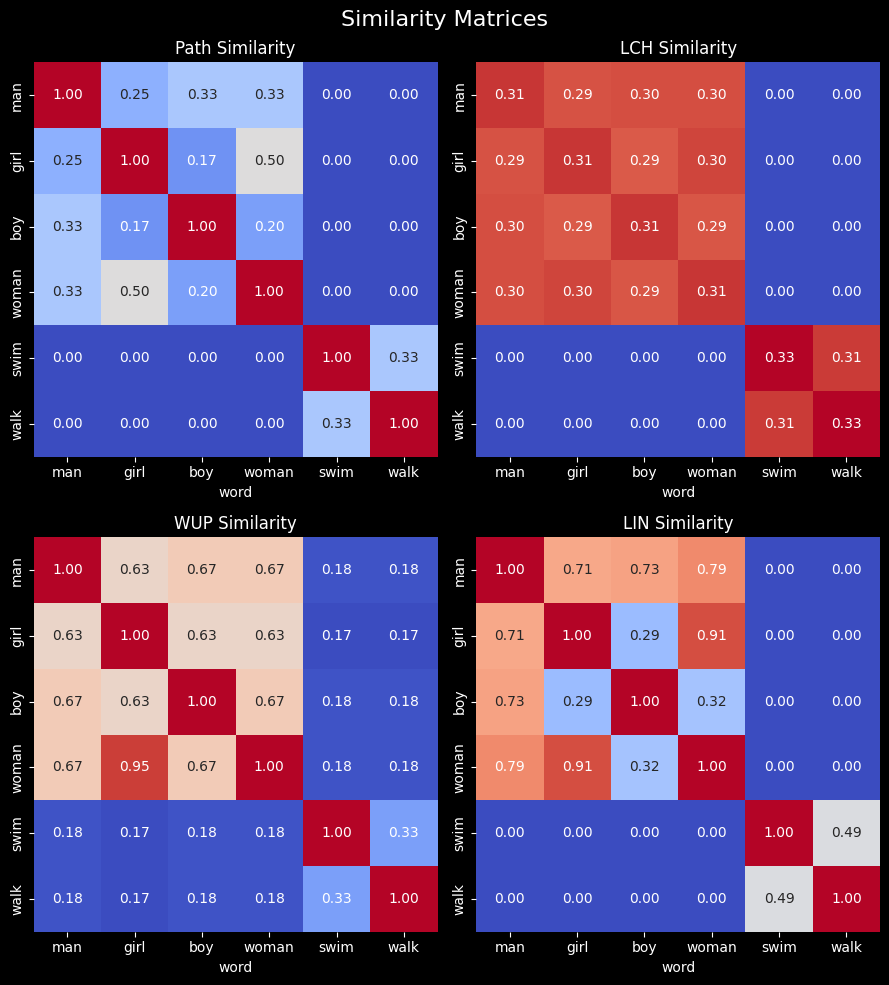

In [15]:
def plot_similarity_matrix(ax, similarity_matrix: pd.DataFrame, title: str):
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, cbar=False)
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(9, 10))

plot_similarity_matrix(axs[0, 0], path_similarities, 'Path Similarity')
plot_similarity_matrix(axs[0, 1], lch_similarities, 'LCH Similarity')
plot_similarity_matrix(axs[1, 0], wup_similarities, 'WUP Similarity')
plot_similarity_matrix(axs[1, 1], lin_similarities, 'LIN Similarity')

fig.suptitle('Similarity Matrices', fontsize=16)
plt.tight_layout()
plt.show()


# Conclusions

- ### What similarity seems better?